In [ ]:
# Load in our libraries
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
plt.style.use('seaborn')
sns.set(font_scale=2)


%matplotlib inline
import torch
import torchvision
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torch
from torchvision import transforms
from PIL import Image

<ipython-input-1-a7f0f56daf37>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
#CUDA 메모리 할당 / 디바이스 할당
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_pickle('/content/gdrive/My Drive/LSWMD.pkl')

Mounted at /content/gdrive


AutoEncoder 사용여부

In [ ]:
autoencoder = str(input('오토인코더 사용여부 O/X == '))
while True:
  if autoencoder == 'O' or autoencoder == 'X':
    break
  else:
    autoencoder = str(input('오토인코더 사용여부 O/X == '))

오토인코더 사용여부 O/X == O


Data 전처리

In [ ]:
# 웨이퍼 맵 => 많은 정보는 없지만 인스턴스 별로 다이 크기가 다름.
# 웨이퍼 맵 차원 검사를 위한 새로운 변수 WaferMapDim 생성
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
342361,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2570.0,lot20521,25.0,[],[],"(60, 55)"
217010,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",599.0,lot13765,7.0,[],[],"(28, 29)"
514095,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...",515.0,lot32116,16.0,[],[],"(25, 27)"
399238,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...",1091.0,lot23885,5.0,[],[],"(37, 37)"
610990,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot38410,23.0,[],[],"(32, 29)"


In [ ]:
# 고장 유형 확인 and class 분류
df['failureNum'] = df.failureType
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
df=df.replace({'failureNum':mapping_type})

/usr/local/lib/python3.10/dist-packages/pandas/core/array_algos/replace.py:86: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [ ]:
#df_withlabel (라벨포함) : 라벨링된 웨이퍼
#df_withpattern (패턴포함): 라벨링&패턴 웨이퍼
#df_nonpattern (패턴미포함) : 라벨링은 됐지만 패턴은 없는 웨이퍼

df_withlabel = df[(df['failureType']!=0)] # 라벨링된 웨이퍼 : failureType = 0이 아닌 df
df_withlabel =df_withlabel.reset_index() #labeled index.

df_withpattern = df_withlabel[(df_withlabel['failureType'] != 'none')]  # 라벨링&패턴 웨이퍼: failureType = none 이 아닌 df
df_withpattern = df_withpattern.reset_index() #patterned index.

df_nonpattern = df_withlabel[(df_withlabel['failureType'] == 'none')] # 라벨은 있고 패턴은 없는 웨이퍼:  failureType == none 인 df
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]


/usr/local/lib/python3.10/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


(172950, 25519, 147431)

In [ ]:
#셔플
df_withpattern = df_withpattern.sample(frac=1).reset_index(drop=True)

In [ ]:
#Data Split
train_rate=0.8

df_withpattern1=pd.DataFrame()
whole=[]
for i in range(8):
  length=0
  T=int(list(df_withpattern.failureNum).count(i)*train_rate)
  for j in range(len(df_withpattern)):
    if length<T and df_withpattern.failureNum.iloc[j]==i:
      length+=1
      whole.append(j)
      df_withpattern1=df_withpattern1.append(df_withpattern.iloc[j])
df_withpattern.drop(whole,axis=0,inplace=True)
df_withpattern1=df_withpattern1.reset_index(drop=True)


In [ ]:
#텐서 데이터 사용
tensor_data_test = df_withpattern['waferMap']
tensor_data=df_withpattern1['waferMap']
print(tensor_data.shape)
print(tensor_data_test.shape)

(20413,)
(5106,)


In [ ]:
tensor_data_test = tensor_data_test.reset_index(drop=True)
tensor_data_test

0       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1,...
2       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...
3       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
                              ...                        
5101    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
5102    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...
5103    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
5104    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
5105    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...
Name: waferMap, Length: 5106, dtype: object

Resize / RGb

In [ ]:
#여러 개의 웨이퍼 크기를 통일하기 위한 resize 함수
def resize(data, Dim0, Dim1):
    transTensor = transforms.ToTensor()
    resizer = transforms.Resize((Dim0, Dim1))
    rwm = torch.ones((1, Dim0, Dim1)).to(DEVICE)
    for i in range(len(data)):
        a = transTensor(data[i].astype('int32'))
        a = resizer(a).reshape((1, Dim0, Dim1)).to(DEVICE)
        rwm = torch.cat([rwm, a])
    x = rwm[1:]
    del rwm
    return x

In [ ]:
#텐서 데이터의 크기를 resize함수를 통해 64,64로 통일

resized_images_test=resize(tensor_data_test,64,64)
resized_images = resize(tensor_data, 64, 64)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
# 3차원의 데이터로 만들기 위한 RGB함수
# 0: 웨이퍼가 아닌 부분 -> R, 1: 정상 웨이퍼 부분 -> G, 2: 결함있는 부분 -> B|

def rgb_sw(x): #rgb 추가
  Dim0 = np.size(x, axis=1)
  Dim1 = np.size(x, axis=2)
  new_x = np.zeros((len(x), Dim0, Dim1, 3)) # 0으로만 이루어진 array 생성
  x = torch.unsqueeze(x,-1) # 차원이 1인 차원 생성
  x = x.to(torch.device('cpu'))
  x = x.numpy()
  for w in range(len(x)):
      for i in range(Dim0):
          for j in range(Dim1):
              new_x[w, i, j, int(x[w, i, j])] = 1
  return new_x
resized_images_test=rgb_sw(resized_images_test)
resized_images = rgb_sw(resized_images)

In [ ]:
#추가 된 채널 확인
print(resized_images.shape)
print(resized_images_test.shape)

(20413, 64, 64, 3)
(5106, 64, 64, 3)


In [ ]:
#데이터 사용을 위해 텐서데이터로 변경
resized_wm = torch.Tensor(np.transpose(resized_images, (0, 3, 1, 2)))
resized_wm_test=torch.Tensor(np.transpose(resized_images_test, (0, 3, 1, 2)))
print(resized_wm.shape)
print(resized_wm_test.shape)

torch.Size([20413, 3, 64, 64])
torch.Size([5106, 3, 64, 64])


In [ ]:
#라벨 및 클래스 지정 및 확인
#레이블 변수 지정
labels_test = df_withpattern['failureType']
labels = df_withpattern1['failureType']

labels_test=labels_test.apply(lambda x: x[0][0])
labels = labels.apply(lambda x: x[0][0])

labels_test=labels_test.replace({'':'none'})
labels = labels.replace({'': 'none'})

labels_test = labels_test.to_numpy()
labels = labels.to_numpy()

labels_test = np.array(labels_test).reshape((-1,1))
labels = np.array(labels).reshape((-1,1))

label_wm_test=labels_test
label_wm = labels

faulty_case = np.unique(labels).flatten().tolist()
np.array(labels, dtype='<U8')
print(faulty_case)

['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch']


Convolutional Autoencoder

In [ ]:
if autoencoder == 'X':
    pass
else:
    #Convolutional Autoencoder
    # parameter
    args = {
        'BATCH_SIZE': 16,
            'LEARNING_RATE': 0.001,
            'NUM_EPOCH': 10
            }

    class ConvAutoEncoder(nn.Module):
        def __init__(self):
            super(ConvAutoEncoder, self).__init__()

            # Encoder
            self.cnn_layer1 = nn.Sequential(
                            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                             nn.MaxPool2d(2,2))

            self.cnn_layer2 = nn.Sequential(
                                    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                     nn.MaxPool2d(2,2))

            # Decoder
            self.tran_cnn_layer1 = nn.Sequential(
                            nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding=0),
                            nn.ReLU())

            self.tran_cnn_layer2 = nn.Sequential(
                            nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding=0),
                            nn.Sigmoid())

        def encoder(self, x):
            encode = self.cnn_layer1(x)
            encode = self.cnn_layer2(encode)
            return encode

        def decoder(self, x):
            decode = self.tran_cnn_layer1(x)
            decode = self.tran_cnn_layer2(decode)
            return decode

        def forward(self, x):
            output = self.encoder(x)
            output = self.decoder(output)
            return output

    model = ConvAutoEncoder().to(DEVICE)
    print(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])


    USE_CUDA = torch.cuda.is_available()
    DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
    train_loader  = torch.utils.data.DataLoader(resized_wm, args['BATCH_SIZE'], shuffle=True)


    steps = 0
    print(resized_wm.shape)
    total_steps = len(train_loader)
    losses =[]
    iterations = []
    for epoch in range(args['NUM_EPOCH']):
        running_loss = 0.0
        for i,wafer in enumerate(train_loader):
            steps += 1
            wafer = wafer.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(wafer)
            loss = criterion(outputs, wafer) #autoencoder loss : compare input & output
            loss.backward()
            running_loss += loss.item()*wafer.shape[0]
            optimizer.step()
            if steps % total_steps == 0:
                model.eval()
                print('Epoch: {}/{}'.format(epoch+1, args['NUM_EPOCH']),
                     "=> loss : %.3f"%(running_loss/total_steps))
                steps = 0
                iterations.append(i)
                losses.append(running_loss / total_steps)
                model.train()


    import torch.nn.init
    # augment function define
    def gen_data(wafer, label):
      gen_x = torch.zeros((1, 3, 64, 64))
      with torch.no_grad():
        encoded_x = model.encoder(wafer).to(torch.device('cpu'))
        # dummy array for collecting noised wafer
        # Make wafer until total # of wafer to 2000
        for i in range((1000//len(wafer)) + 1):
          noised_encoded_x = (encoded_x + torch.from_numpy(np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 32, 16, 16))).to(torch.device('cpu'))).to(DEVICE)
          noised_decoded_x = model.decoder(noised_encoded_x.float()).to(torch.device('cpu'))
          gen_x = torch.cat([gen_x, noised_decoded_x], axis=0)
        # also make label vector with same length
        gen_y = np.full((len(gen_x), 1), label)
        # return date without 1st dummy data.
      del encoded_x, noised_encoded_x, noised_decoded_x
      return gen_x, gen_y


    faulty_case = np.unique(label_wm)
    print(faulty_case)


    # Augmentation for all faulty case.
    for f in faulty_case :
        # skip none case
        if f == 'none' :
            continue
        gen_x, gen_y = gen_data(resized_wm[np.where(label_wm==f)[0]].to(DEVICE), f)
        resized_wm = torch.cat([resized_wm.to(torch.device('cpu')), gen_x], axis=0)
        label_wm = np.concatenate((label_wm, gen_y))

    print('After Generate resized_wm shape : {}, label_wm shape : {}'.format(resized_wm.shape, label_wm.shape))

ConvAutoEncoder(
  (cnn_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tran_cnn_layer1): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (tran_cnn_layer2): Sequential(
    (0): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (1): Sigmoid()
  )
)
torch.Size([20413, 3, 64, 64])
Epoch: 1/10 => loss : 0.705
Epoch: 2/10 => loss : 0.275
Epoch: 3/10 => loss : 0.215
Epoch: 4/10 => loss : 0.187
Epoch: 5/10 => loss : 0.167
Epoch: 6/10 => loss : 0.154
Epoch: 7/10 => loss : 0.145
Epoch: 8/10 => loss : 0.138
Epoch: 9/10 => loss : 0.133
Epoch: 10/10 => loss : 0.128
['Center' 'D

모델 학습

In [ ]:
# Transforms 정의

# 학습 데이터용 : 정규화에 반전과 RandomErasing 추가
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.Normalize(0.5, 0.5),
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# 검증 데이터용 : 정규화만 실시
transform = transforms.Compose([
  transforms.Normalize(0.5, 0.5)
])

In [ ]:
# one-hot-encoding
for i, l in enumerate(faulty_case):
    label_wm[label_wm==l] = i
    label_wm_test[label_wm_test==l] = i
    print('i : {}, l : {}'.format(i, l))
def _to_one_hot(y, num_classes):
    scatter_dim = len(y.size())
    y_tensor = y.view(*y.size(), -1)
    zeros = torch.zeros(*y.size(), num_classes, dtype=y.dtype)
    return zeros.scatter(scatter_dim, y_tensor, 1)
label_wm_test = _to_one_hot(torch.as_tensor(np.int64(label_wm_test)), num_classes=8)
label_wm = _to_one_hot(torch.as_tensor(np.int64(label_wm)), num_classes=8)

i : 0, l : Center
i : 1, l : Donut
i : 2, l : Edge-Loc
i : 3, l : Edge-Ring
i : 4, l : Loc
i : 5, l : Near-full
i : 6, l : Random
i : 7, l : Scratch


In [ ]:
# ResNet : residual block이 겹겹이 쌓여 구성된 모델
# residual block 정의

import torch.utils.data as data
class BasicDataset(data.Dataset):
  def __init__(self,data,label,transform):
    super(BasicDataset, self).__init__()
    self.data=data
    self.label=label
    self.transform=transform
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    sample_X = self.data[idx]
    sample_y = self.label[idx]
    if self.transform:
      sample_X = self.transform(sample_X)
    return sample_X, sample_y
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=8, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [ ]:
from sklearn.model_selection import train_test_split

# train : test = 8 : 2


# 전체 데이터를 train, test로 분할
train_X, test_X, train_Y, test_Y = train_test_split(resized_wm, label_wm, train_size=0.8, random_state=42)
a=torch.cat((train_X,test_X))
b=torch.cat((train_Y,test_Y))
# 데이터셋 생성
dataset_train = BasicDataset(a, b, transform=transform_train)
dataset_test = BasicDataset(resized_wm_test, label_wm_test, transform=transform)

In [ ]:
model = resnet34().to(DEVICE)

In [ ]:
args = {
	'BATCH_SIZE': 256,
        'LEARNING_RATE': 0.001,
        'NUM_EPOCH': 10
        }

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(DEVICE) # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])
torch.manual_seed(42)

In [ ]:
# 추가
class SaveBestModel:
    def __init__(
        self, best_train_loss=float('inf')
    ):
        self.best_train_loss = best_train_loss

    def __call__(
        self, current_train_loss,
        epoch, model, optimizer, criterion
    ):
        if current_train_loss < self.best_train_loss:
            self.best_train_loss = current_train_loss
            print(f"\nBest train loss: {self.best_train_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/best_model.pth')

save_best_model = SaveBestModel()

In [ ]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE).reshape(args['BATCH_SIZE'], 8)
        optimizer.zero_grad()
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        train_correct += (predictions == labels).sum().item()
    print(train_correct)
    return train_loss,train_correct

def test_epoch(model, dataloader, loss_fn):
    test_loss, test_correct = 0.0, 0
    model.eval()
    y_true, y_pred = [], []
    for images, labels in dataloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE).reshape(args['BATCH_SIZE'], 8)
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss=loss_fn(output, labels)
        test_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        test_correct += (predictions == labels).sum().item()
        y_true += labels.tolist()
        y_pred += predictions.tolist()
    return test_loss, test_correct, y_true, y_pred


In [ ]:
import os

# create 'outputs' directory if it doesn't exist
if not os.path.exists('outputs'):
    os.makedirs('outputs')

# specify model saving path relative to 'outputs' directory
model_path = 'outputs/best_model.pt'

In [ ]:
load = False
if load == False:
    train_loader = DataLoader(dataset_train, batch_size=args['BATCH_SIZE'], drop_last=True)
    history = {'train_loss': [], 'train_acc':[]}

    for epoch in range(args['NUM_EPOCH']):
      train_loss, train_correct=train_epoch(model,train_loader,criterion,optimizer)
      train_loss = train_loss / len(train_loader.sampler)
      train_acc = train_correct / len(train_loader.sampler) * 100

      print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Training Acc: {:.2f} % ".format(epoch + 1, args['NUM_EPOCH'],train_loss ,train_acc))
      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      save_best_model(
          train_loss, epoch, model, optimizer, criterion
           )
    # load best model
    checkpoint = torch.load('outputs/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # test model using test_epoch function
    test_loader = DataLoader(dataset_test, batch_size=args['BATCH_SIZE'], drop_last=True)
    test_loss, test_correct, y_true, y_pred = test_epoch(model, test_loader, criterion)

    # calculate test set accuracy and loss
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * test_correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.3f} Test Accuracy: {test_acc:.2f}%")
else:
    # load best model
    checkpoint = torch.load('outputs/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # test model using test_epoch function
    test_loader = DataLoader(dataset_test, batch_size=args['BATCH_SIZE'], drop_last=True)
    test_loss, test_correct, y_true, y_pred = test_epoch(model, test_loader, criterion)

    # calculate test set accuracy and loss
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * test_correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.3f} Test Accuracy: {test_acc:.2f}%")

35387
Epoch:1/10 AVG Training Loss:0.524 AVG Training Acc: 79.84 % 

Best train loss: 0.524422108481507

Saving best model for epoch: 1

38778
Epoch:2/10 AVG Training Loss:0.334 AVG Training Acc: 87.50 % 

Best train loss: 0.33381857415829325

Saving best model for epoch: 2

39901
Epoch:3/10 AVG Training Loss:0.267 AVG Training Acc: 90.03 % 

Best train loss: 0.2673504706324223

Saving best model for epoch: 3

40481
Epoch:4/10 AVG Training Loss:0.233 AVG Training Acc: 91.34 % 

Best train loss: 0.23272159280329405

Saving best model for epoch: 4

40884
Epoch:5/10 AVG Training Loss:0.207 AVG Training Acc: 92.25 % 

Best train loss: 0.20679606487604685

Saving best model for epoch: 5

41237
Epoch:6/10 AVG Training Loss:0.190 AVG Training Acc: 93.04 % 

Best train loss: 0.1895159081861861

Saving best model for epoch: 6

41543
Epoch:7/10 AVG Training Loss:0.170 AVG Training Acc: 93.73 % 

Best train loss: 0.1704945318535347

Saving best model for epoch: 7

41863
Epoch:8/10 AVG Training Lo

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


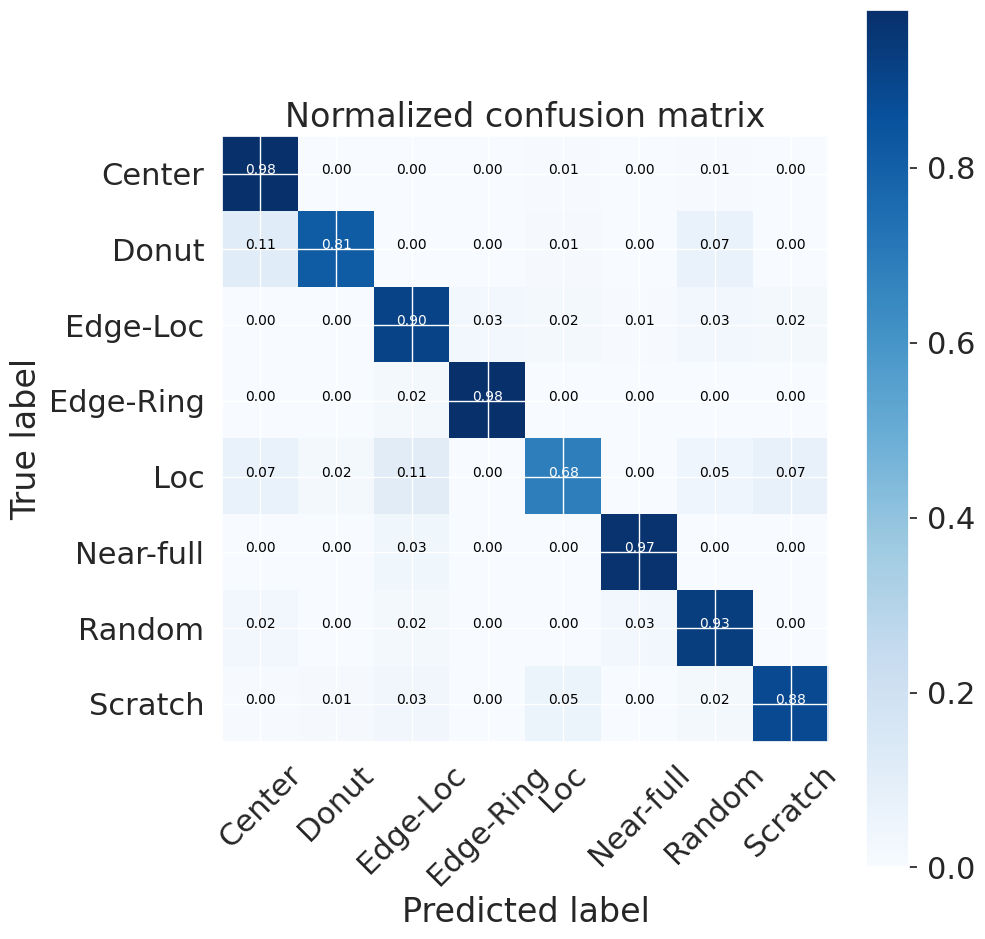

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

test_loss, test_correct, y_true, y_pred = test_epoch(model, test_loader, criterion)

cm = confusion_matrix(y_true, y_pred)
classes = [str(i) for i in range(8)]

# Plot the confusion matrix with larger font size
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 10})  # 폰트 크기 조정
plot_confusion_matrix(cm, faulty_case, normalize=True, title='Normalized confusion matrix')
plt.show()
